Cередня кількість поїздок та дохід для кожного дня тижня за останній місяць

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr

# Create SparkSession
spark = SparkSession.builder \
    .appName("SimpleApp") \
    .getOrCreate()



your 131072x1 screen size is bogus. expect trouble
25/04/16 12:14:28 WARN Utils: Your hostname, DESKTOP-DP2FLCF resolves to a loopback address: 127.0.1.1; using 172.22.104.161 instead (on interface eth0)
25/04/16 12:14:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/16 12:14:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df_fare_init = spark.read.option("header", True).option("inferSchema", True).csv("../data_lake/trip_fare_1.csv")
df_trip_init = spark.read.option("header", True).option("inferSchema", True).csv("../data_lake/trip_data_1.csv")

In [3]:
for column in df_fare_init.columns:
    df_fare_init = df_fare_init.withColumnRenamed(column, column.strip().replace(" ", "_"))

In [ ]:
from pyspark.sql.functions import to_date, lit

df_trip = df_trip_init.filter(
    (col("passenger_count") > 0) & (col("passenger_count") <= 10) &
    (col("trip_time_in_secs") > 0) &
    (col("trip_distance") > 0) &
    (col("pickup_latitude").between(40.5, 41.0)) &
    (col("dropoff_latitude").between(40.5, 41.0)) &
    (col("pickup_longitude").between(-74.5, -73.0)) &
    (col("dropoff_longitude").between(-74.5, -73.0)) &
    (col("pickup_datetime") <= lit("2013-01-27"))
)

df_fare = df_fare_init.filter(
    (col("fare_amount") >= 0) &
    (col("tip_amount") >= 0) &
    (col("tolls_amount") >= 0) &
    (col("total_amount") >= 0) &
    ((col("fare_amount") > 0) | (col("payment_type") == "NOC")) &
    (col("pickup_datetime") <= lit("2013-01-27"))
)

In [52]:
df = df_trip.join(df_fare, ["medallion", "hack_license", "pickup_datetime", "vendor_id"])

In [53]:
from pyspark.sql.functions import to_date, date_format, count, sum as Fsum, avg, col, lit, when

df_last_month = df.withColumn("trip_date", to_date("pickup_datetime")) \
    .withColumn("weekday", date_format("trip_date", "EEEE"))

daily_totals = df_last_month.groupBy("trip_date", "weekday").agg(
    count("*").alias("daily_trip_count"),
    Fsum("total_amount").alias("total_income_day")
)

avg_income_by_weekday = daily_totals.groupBy("weekday").agg(
    avg("daily_trip_count").alias("avg_trip_count"),
    avg("total_income_day").alias("avg_total_income")
)

In [54]:
from pyspark.sql.functions import when

ordered = avg_income_by_weekday.withColumn("weekday_order", 
    when(col("weekday") == "Monday", 1)
    .when(col("weekday") == "Tuesday", 2)
    .when(col("weekday") == "Wednesday", 3)
    .when(col("weekday") == "Thursday", 4)
    .when(col("weekday") == "Friday", 5)
    .when(col("weekday") == "Saturday", 6)
    .when(col("weekday") == "Sunday", 7)
)

ordered.orderBy("weekday_order").drop("weekday_order").show(truncate=False)


25/04/16 17:09:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 17:09:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 17:09:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 17:09:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 17:09:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 17:09:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 17:09:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 17:09:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 17:09:55 WARN RowBasedKeyValueBatch: Calling spill() on

+---------+--------------+------------------+
|weekday  |avg_trip_count|avg_total_income  |
+---------+--------------+------------------+
|Monday   |222145.5      |3166949.8899999904|
|Tuesday  |279585.8      |3989774.8199999793|
|Wednesday|259711.0      |3670459.4139999873|
|Thursday |292052.8      |4085750.3259999817|
|Friday   |363154.5      |5064692.622499984 |
|Saturday |348169.0      |4653400.507499991 |
|Sunday   |346055.75     |4868467.8949999865|
+---------+--------------+------------------+



In [40]:
ordered.coalesce(1).write.mode("overwrite").option("header", True).csv("./results/avg_trips_by_day_of_week.csv")

25/04/16 16:12:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 16:12:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 16:12:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 16:12:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 16:12:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 16:12:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 16:12:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 16:12:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 16:12:07 WARN RowBasedKeyValueBatch: Calling spill() on

25/04/16 16:51:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 16:51:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 16:51:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 16:51:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 16:51:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 16:51:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 16:51:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 16:51:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/16 16:51:47 WARN RowBasedKeyValueBatch: Calling spill() on

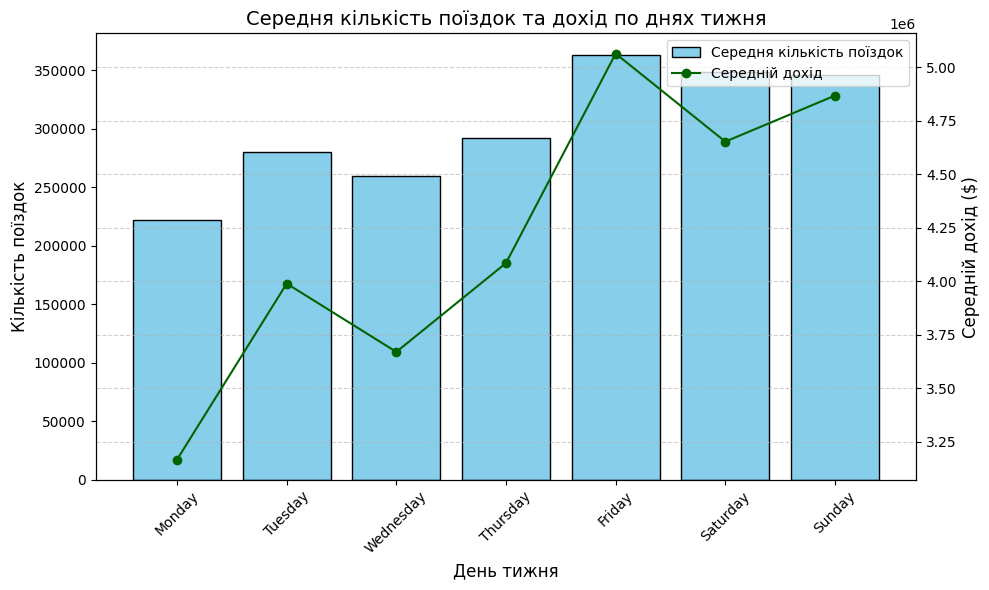

In [50]:
import matplotlib.pyplot as plt

pandas_df = ordered.orderBy("weekday_order").toPandas()

days = pandas_df["weekday"]
avg_trips = pandas_df["avg_trip_count"]
avg_income = pandas_df["avg_total_income"]

fig, ax1 = plt.subplots(figsize=(10, 6))

bar1 = ax1.bar(days, avg_trips, color='skyblue', label='Середня кількість поїздок', edgecolor='black')
ax1.set_ylabel("Кількість поїздок", fontsize=12)
ax1.set_xlabel("День тижня", fontsize=12)
ax1.tick_params(axis='y')
ax1.set_xticklabels(days, rotation=45)

ax2 = ax1.twinx()
line1 = ax2.plot(days, avg_income, color='darkgreen', marker='o', label='Середній дохід')
ax2.set_ylabel("Середній дохід ($)", fontsize=12)
ax2.tick_params(axis='y')

plt.title("Середня кількість поїздок та дохід по днях тижня", fontsize=14)
fig.tight_layout()
fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

